# CE888 Lab7 Transfer Learning: Exercise 1

>
**Note:**<br>
On [Colaboratory](https://colab.research.google.com/notebooks/welcome.ipynb), 
1. From *File*, create a new python3 notebook
2. From *Runtime*, go to *change runtime type* and select GPU or TPU as hardware accelerator
3. From *File*, go to *upload* and upload example notebook files
4. From `>` on the left of the browser, select *file* and upload files (data.zip, vgg16.py and elephant.jpg)

**Reference:**<br>
This sample code uses `VGG16` model, which is a **convolutional neural network architecture** named after the Visual Geometry Group from Oxford, who developed it (see [The Keras Blog](https://blog.keras.io/how-convolutional-neural-networks-see-the-world.html))
>

In [14]:
# Upload data
from zipfile import ZipFile
file_name = "data.zip"

with ZipFile(file_name, 'r') as zip:
    zip.extractall()
    print('done')

done


Install packages tensorflow 1.3.0 and keras 2.0.7

In [15]:
!pip install tensorflow==1.3.0
!pip install keras==2.0.7

In [0]:
import numpy as np
import os
import time
from vgg16 import VGG16
from keras.preprocessing import image
from keras.applications.imagenet_utils import preprocess_input
from keras.applications.imagenet_utils import decode_predictions
from keras.layers import Dense, Activation, Flatten
from keras.layers import merge, Input
from keras.models import Model
from keras.utils import np_utils
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split

In [17]:
#%% Load an elephant image as an example and see the image-processing

img_path = 'elephant.jpg' # image name
img = image.load_img(img_path, target_size=(224, 224)) # load image
x = image.img_to_array(img) # convert image to array
print ("Shape of the loaded image '%s':" % img_path, x.shape)

x = np.expand_dims(x, axis=0) # expand dimension
print ("Expanded dimension:", x.shape)

# preprocess_input method in keras process the data into the format 
# required by the model
x = preprocess_input(x) 
print('Input image shape:', x.shape)

Shape of the loaded image 'elephant.jpg': (224, 224, 3)
Expanded dimension: (1, 224, 224, 3)
Input image shape: (1, 224, 224, 3)


In [18]:
#%% Loading the training data
PATH = os.getcwd()
# Define data path
data_path = PATH + '/data'
data_dir_list = os.listdir(data_path)
print("Directories under '/data':", data_dir_list)

Directories under '/data': ['horses', 'cats', 'Humans', 'dogs']


In [19]:
img_data_list=[] # created an empty list for images to be loaded

for dataset in data_dir_list:
	img_list=os.listdir(data_path+'/'+ dataset)
	print ('Loaded the images of dataset-'+'\'{}\'\n'.format(dataset))
	for img in img_list:
		#print (" Image file name: %s\t| " % img, end = "")
		img_path = data_path + '/'+ dataset + '/'+ img
		img = image.load_img(img_path, target_size=(224, 224))
		x = image.img_to_array(img)
		x = np.expand_dims(x, axis=0)
		x = preprocess_input(x)
#		x = x/255
		#print('Input image shape:', x.shape)
		img_data_list.append(x)

#%% 
img_data = np.array(img_data_list)
#img_data = img_data.astype('float32')
print ("List for images to be loaded:", img_data.shape)

img_data=np.rollaxis(img_data,1,0)
print ("Roll the specified axis backwards:", img_data.shape)

img_data=img_data[0]
print ("img_data[0]:", img_data.shape)

Loaded the images of dataset-'horses'

Loaded the images of dataset-'cats'

Loaded the images of dataset-'Humans'

Loaded the images of dataset-'dogs'

List for images to be loaded: (808, 1, 224, 224, 3)
Roll the specified axis backwards: (1, 808, 224, 224, 3)
img_data[0]: (808, 224, 224, 3)


In [20]:
# Define the number of classes
num_classes = 4
print("Number of samples:", img_data.shape[0])
num_of_samples = img_data.shape[0]
labels = np.ones((num_of_samples,),dtype='int64')

labels[0:202]=0
labels[202:404]=1
labels[404:606]=2
labels[606:]=3
print("label 1:", labels[201])
print("label 2:", labels[202])
print("label 3:", labels[404])
print("label 4:", labels[606])

names = ['cats','dogs','horses','humans']

# convert class labels to on-hot encoding
Y = np_utils.to_categorical(labels, num_classes)

#Shuffle the dataset
x,y = shuffle(img_data,Y, random_state=2)

# Split the dataset
X_train, X_test, y_train, y_test = \
     train_test_split(x, y, test_size=0.2, random_state=2)
print("Number of training samples: %d | test samples: %d" % \
     (len(X_train), len(X_test)))

Number of samples: 808
label 1: 0
label 2: 1
label 3: 2
label 4: 3
Number of training samples: 646 | test samples: 162


In [21]:
image_input = Input(shape=(224, 224, 3)) # shape of a single image
print("Input", image_input)

# load VGG-16 model with 'top = true'
model = VGG16(input_tensor=image_input, include_top=True, weights='imagenet') 
print("\nVGG Model Summary:")
model.summary()

Input Tensor("input_2:0", shape=(?, 224, 224, 3), dtype=float32)

VGG Model Summary:
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 224, 224, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________

In [22]:
last_layer = model.get_layer('fc2').output
#x= Flatten(name='flatten')(last_layer)

# define the output layer using the output of vgg model as input
out = Dense(num_classes, activation='softmax', name='output')(last_layer)
custom_vgg_model = Model(image_input, out)
custom_vgg_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 224, 224, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0         
__________

In [23]:
i=0
for layer in custom_vgg_model.layers[:-1]:
	print("Layer %2d: trainable=%s" % (i, layer.trainable))
	i+=1
	layer.trainable = False
  
custom_vgg_model.layers[3].trainable
custom_vgg_model.summary()

# compile the model
custom_vgg_model.compile(loss='categorical_crossentropy',optimizer=\
                         'rmsprop',metrics=['accuracy'])

Layer  0: trainable=False
Layer  1: trainable=True
Layer  2: trainable=True
Layer  3: trainable=True
Layer  4: trainable=True
Layer  5: trainable=True
Layer  6: trainable=True
Layer  7: trainable=True
Layer  8: trainable=True
Layer  9: trainable=True
Layer 10: trainable=True
Layer 11: trainable=True
Layer 12: trainable=True
Layer 13: trainable=True
Layer 14: trainable=True
Layer 15: trainable=True
Layer 16: trainable=True
Layer 17: trainable=True
Layer 18: trainable=True
Layer 19: trainable=True
Layer 20: trainable=True
Layer 21: trainable=True
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 224, 224, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)    

In [24]:
t=time.time()
#	t = now()
hist = custom_vgg_model.fit(X_train, y_train, batch_size=32, epochs=2, \
                            verbose=1, validation_data=(X_test, y_test))
print('Training time: %s' % (t - time.time()))
(loss, accuracy) = custom_vgg_model.evaluate(X_test, y_test, batch_size=10, \
                                             verbose=1)

print("[INFO] loss={:.4f}, accuracy: {:.4f}%".format(loss,accuracy * 100))

Train on 646 samples, validate on 162 samples
Epoch 1/2
646/646 [==============================] - 1491s - loss: 0.3267 - acc: 0.8963 - val_loss: 0.0949 - val_acc: 0.9691
Epoch 2/2
646/646 [==============================] - 1319s - loss: 0.0343 - acc: 0.9923 - val_loss: 0.1043 - val_acc: 0.9691
Training time: -2810.729226589203
162/162 [==============================] - 267s   
[INFO] loss=0.1043, accuracy: 96.9136%


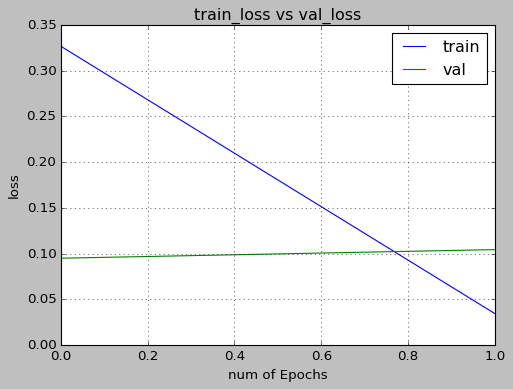

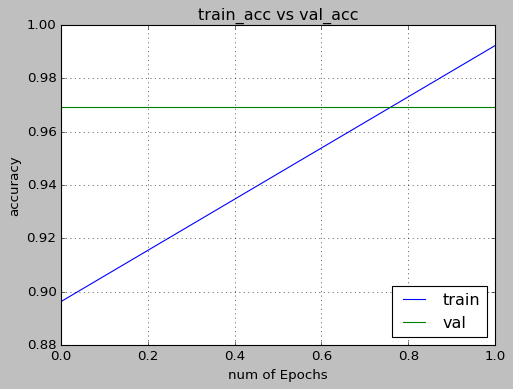

In [25]:
#%% plot
import matplotlib.pyplot as plt
# visualizing losses and accuracy
train_loss=hist.history['loss']
val_loss=hist.history['val_loss']
train_acc=hist.history['acc']
val_acc=hist.history['val_acc']
xc=range(2)

plt.figure(1,figsize=(7,5))
plt.plot(xc,train_loss)
plt.plot(xc,val_loss)
plt.xlabel('num of Epochs')
plt.ylabel('loss')
plt.title('train_loss vs val_loss')
plt.grid(True)
plt.legend(['train','val'])
#print plt.style.available # use bmh, classic,ggplot for big pictures
plt.style.use(['classic'])

plt.figure(2,figsize=(7,5))
plt.plot(xc,train_acc)
plt.plot(xc,val_acc)
plt.xlabel('num of Epochs')
plt.ylabel('accuracy')
plt.title('train_acc vs val_acc')
plt.grid(True)
plt.legend(['train','val'],loc=4)
#print plt.style.available # use bmh, classic,ggplot for big pictures
plt.style.use(['classic'])